In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import torch
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
import torch_geometric.transforms as T
from torch_geometric.datasets import IMDB
import matplotlib.pyplot as plt

## IMDB

In [2]:
dataset = IMDB(root='./imdb_data')
data = dataset[0]
movie = data['movie'].x.tolist()
df = pd.DataFrame(movie)
df['class'] = data['movie'].y.tolist()
class0 = df[df['class'] == 0].drop(['class'], axis=1)

Extracting imdb_data/raw/IMDB_processed.zip
Processing...
Done!


Feature selection from Bag-of-Words features of Movie node

In [3]:
# Feature selection for Movie class 0
# selects top k features with most number of 1s
col_sum = class0.sum(axis=0)
sorted_colsum = sorted(col_sum, reverse=True)
colsum_df = pd.DataFrame(col_sum)

sorted_colsum = sorted(col_sum, reverse=True)[:8]
index_list = list(np.ravel(colsum_df[colsum_df[0].isin(sorted_colsum)].index))

imp_feat0 = class0[index_list]
imp_feat0 = imp_feat0.drop(imp_feat0[imp_feat0.sum(axis=1) == 0.0].index)
imp_feat0.head()

,87,102,1023,1381,1812,1928,2095,2746
3,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
8,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
13,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
# Feature selection for Movie class 1
class1 = df[df['class'] == 1].drop(['class'], axis=1)

col_sum = class1.sum(axis=0)
sorted_colsum = sorted(col_sum, reverse=True)
colsum_df = pd.DataFrame(col_sum)

sorted_colsum = sorted(col_sum, reverse=True)[:5]
index_list = list(np.ravel(colsum_df[colsum_df[0].isin(sorted_colsum)].index))

imp_feat1 = class1[index_list]
imp_feat1 = imp_feat1.drop(imp_feat1[imp_feat1.sum(axis=1) == 0.0].index)
imp_feat1.head()

,1023,1111,1381,1624,2774
29,0.0,0.0,1.0,0.0,0.0
34,0.0,1.0,0.0,0.0,0.0
48,1.0,0.0,0.0,0.0,0.0
77,1.0,0.0,0.0,1.0,0.0
107,0.0,0.0,0.0,1.0,0.0


In [5]:
# Feature selection for Movie class 2
class2 = df[df['class'] == 2].drop(['class'], axis=1)

col_sum = class2.sum(axis=0)
sorted_colsum = sorted(col_sum, reverse=True)
colsum_df = pd.DataFrame(col_sum)

sorted_colsum = sorted(col_sum, reverse=True)[:5]
index_list = list(np.ravel(colsum_df[colsum_df[0].isin(sorted_colsum)].index))

imp_feat2 = class2[index_list]
imp_feat2 = imp_feat2.drop(imp_feat2[imp_feat2.sum(axis=1) == 0.0].index)
imp_feat2.head()

,747,1023,1624,1654,1900
21,0.0,0.0,1.0,0.0,0.0
117,1.0,0.0,0.0,0.0,0.0
252,1.0,0.0,0.0,0.0,0.0
343,0.0,0.0,1.0,0.0,0.0
348,0.0,0.0,1.0,0.0,0.0


### Features of each class of Movie node sampled using Diffusion Models

In [6]:
sampled0  = pd.DataFrame(torch.load('../sampled_features/imdb/features0.pt')[0].cpu().numpy())
sampled0.head()

,0,1,2,3,4,5,6,7
0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
sampled1  = pd.DataFrame(torch.load('../sampled_features/imdb/features1.pt')[0].cpu().numpy())
sampled1.head()

,0,1,2,3,4
0,0.0,1.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0
4,0.0,2.0,0.0,0.0,0.0


In [9]:
sampled2  = pd.DataFrame(torch.load('../sampled_features/imdb/features2.pt')[0].cpu().numpy())
sampled2.head()

,0,1,2,3,4
0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,1.0,0.0,0.0
2,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0
4,1.0,2.0,1.0,0.0,0.0


### Comparison of real and synthetic distributions for the most important feature

In [10]:
def cosine_sim(original,sampled):
    return cosine_similarity(original, sampled)

In [11]:
def feature_selection(df_sampled):
    col_sum = df_sampled.sum(axis=0)
    sorted_colsum = sorted(col_sum, reverse=True)

    index_list = []
    for i in sorted_colsum[:1]:
        index_list.append(list(col_sum).index(i))
        imp_feat = df_sampled[index_list].reset_index(drop=True)
        return imp_feat, index_list

In [12]:
def count_plot(df,ind):

    fig, ax = plt.subplots(figsize=(7, 7))
    sns.countplot(data=df,x=ind,width=0.3,ax=ax)
    #https://www.geeksforgeeks.org/how-to-show-values-on-seaborn-barplot/
    for i in ax.containers:
        ax.bar_label(i,fontsize=15)
    plt.xticks(fontsize=15)

    plt.yticks(fontsize=15)
    plt.xlabel('feature values',fontsize=15)
    plt.ylabel('no. of samples',fontsize=15)

    plt.show()

Movie class 0

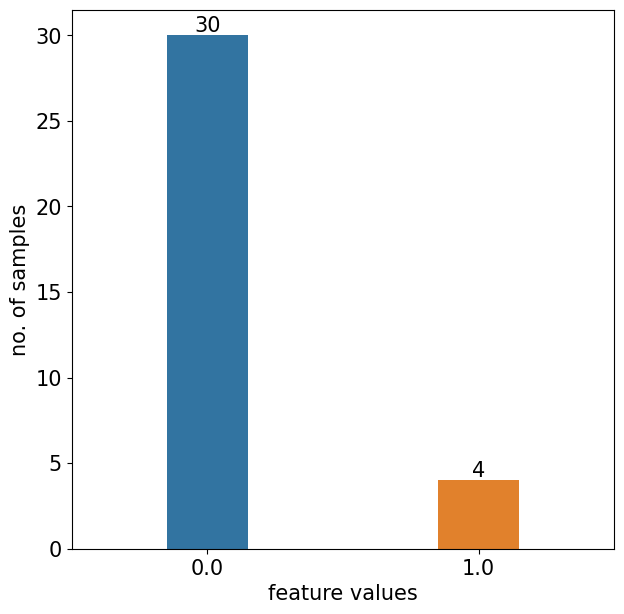

In [13]:
#Real
real_class0= np.array(imp_feat0)
syn_imp_feat0,index_list = feature_selection(sampled0)
syn_ind0=index_list[0]
real_imp_feat0, index_list = feature_selection(pd.DataFrame(real_class0))
real_ind0=index_list[0]
count_plot(pd.DataFrame(real_class0)[:syn_imp_feat0.shape[0]], real_ind0)

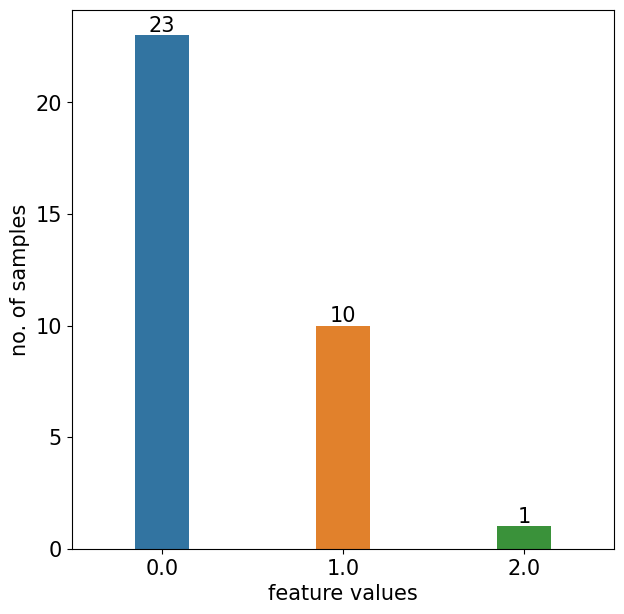

In [14]:
#Synthetic
count_plot(sampled0, syn_ind0)

Movie class 1

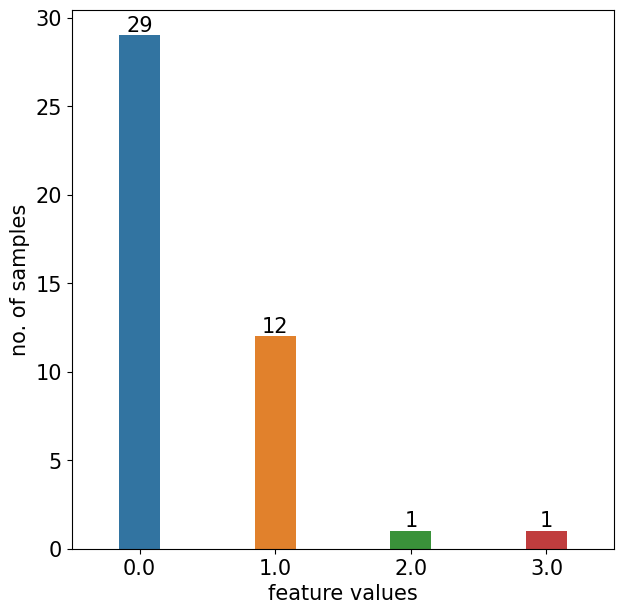

In [15]:
#Real
real_class1= np.array(imp_feat1)
syn_imp_feat1,index_list = feature_selection(sampled1)
syn_ind1=index_list[0]
real_imp_feat1, index_list = feature_selection(pd.DataFrame(real_class1))
real_ind1=index_list[0]
count_plot(pd.DataFrame(real_class1)[:syn_imp_feat1.shape[0]], real_ind1)

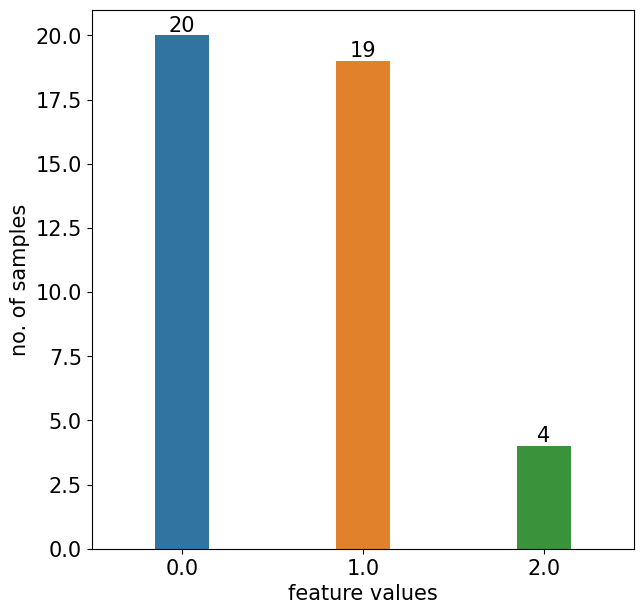

In [16]:
#Synthetic
count_plot(sampled1, syn_ind1)

Movie class 2

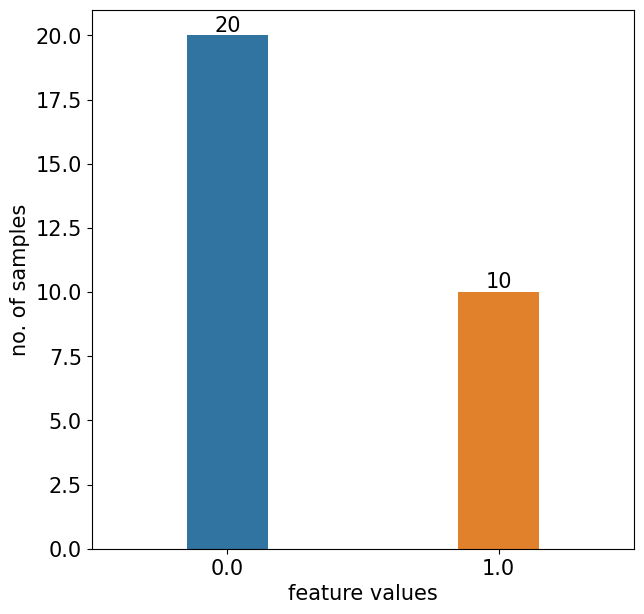

In [17]:
#Real
real_class2= np.array(imp_feat2)
syn_imp_feat2,index_list = feature_selection(sampled2)
syn_ind2=index_list[0]
real_imp_feat2, index_list = feature_selection(pd.DataFrame(real_class2))
real_ind2=index_list[0]
count_plot(pd.DataFrame(real_class2)[:syn_imp_feat2.shape[0]], real_ind2)

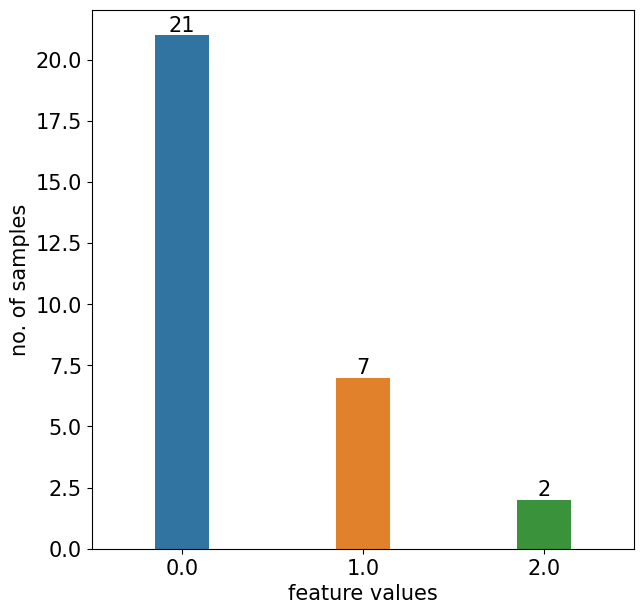

In [18]:
#Synthetic
count_plot(sampled2, syn_ind2)

### Pairwise cosine similarity of all features for real and synthetic distributions

Movie class 0

In [19]:
cosine_sim(real_class0,sampled0)

array([[0.        , 0.        , 1.        , ..., 1.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.70710678, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<Axes: >

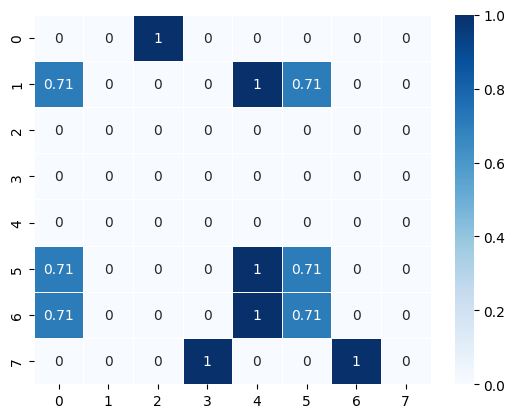

In [20]:
sns.heatmap(cosine_sim(real_class0[:8],sampled0[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)

Movie class 1

In [21]:
cosine_sim(real_class1,sampled1)

array([[0.        , 0.        , 0.        , ..., 1.        , 0.        ,
        0.        ],
       [1.        , 0.        , 0.70710678, ..., 0.        , 0.70710678,
        0.        ],
       [0.        , 1.        , 0.70710678, ..., 0.        , 0.70710678,
        1.        ],
       ...,
       [1.        , 0.        , 0.70710678, ..., 0.        , 0.70710678,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

<Axes: >

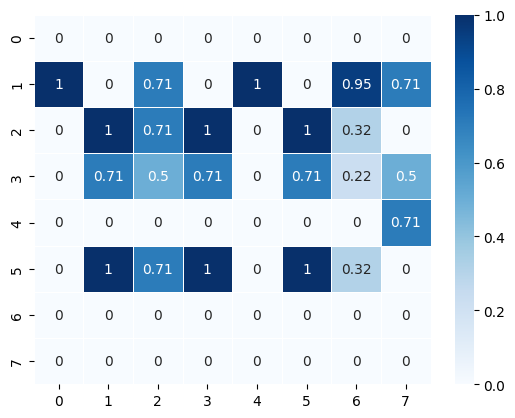

In [22]:
sns.heatmap(cosine_sim(real_class1[:8],sampled1[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)

Movie class 2

In [23]:
cosine_sim(real_class2,sampled2)

array([[0.        , 1.        , 0.        , ..., 0.        , 0.80178373,
        0.70710678],
       [0.        , 0.        , 0.        , ..., 1.        , 0.26726124,
        0.        ],
       [0.        , 0.        , 0.        , ..., 1.        , 0.26726124,
        0.        ],
       ...,
       [0.70710678, 0.        , 0.        , ..., 0.        , 0.37796447,
        0.5       ],
       [0.5547002 , 0.        , 0.83205029, ..., 0.        , 0.        ,
        0.39223227],
       [0.        , 0.        , 0.        , ..., 1.        , 0.26726124,
        0.        ]])

<Axes: >

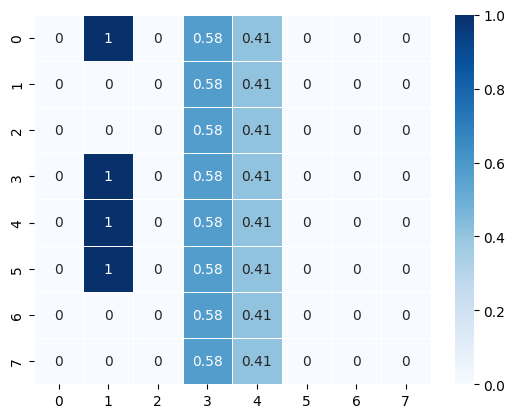

In [24]:
sns.heatmap(cosine_sim(real_class2[:8],sampled2[:8]), 
            xticklabels = 1, yticklabels = 1, annot=True, cmap='Blues', linewidth=.5)